# Interpolation

(see https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate)

In this example, we will interpolate data in one and two dimensions. Interpolation is necessary if you have data available only for discrete locations, but you would like to know what the data inbetween those discrete locations look like. Note that interpolation is different from function fitting: while the latter requires a mathematical model function that is fitted to the data, interpolation makes no assumption on what functional behavior the data might be based on.

It is important to be aware that interpolation is always associated with uncertainty: it cannot magically reveal details that fall between the discrete locations (good example: movies in which the police has noisy surveillance camera images and then magically create a license plate code from that).

## One-dimensional Interpolation

Imagine you measure a signal that is a function of only one variable (https://raw.githubusercontent.com/mommermi/Introduction-to-Python-for-Scientists/master/notebooks/signal.csv) and you would like to know what this signal looks like between the discrete measurement, for instance, because you want to integrate the signal over time.

Once again, let's plot the signal first.

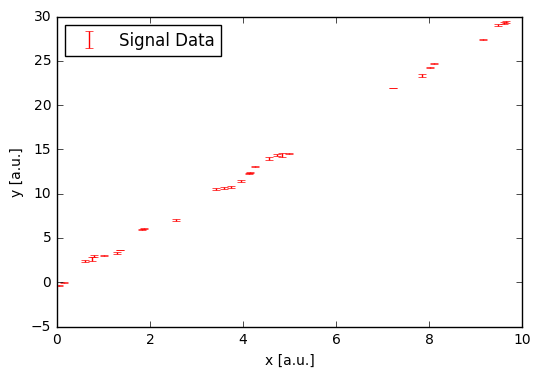

In [1]:
# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# read in signal.csv
data = np.genfromtxt('signal.csv', delimiter=',', 
                     dtype=[('x', float), ('y', float), ('yerr', float)])

f, ax = plt.subplots()

ax.errorbar(data['x'], data['y'], yerr=data['yerr'], linestyle='', color='red', label='Signal Data')

ax.set_xlabel('x [a.u.]')
ax.set_ylabel('y [a.u.]')

ax.legend(numpoints=1, loc=2)

plt.show()

We use `scipy.interpolate.interp1d` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d) and different interpolation methods to interpolate the data. We also compare the different interpolation functions to the fit that we derived for this data set last week (https://github.com/mommermi/Introduction-to-Python-for-Scientists/blob/master/notebooks/Function_Fitting_20161028.ipynb).

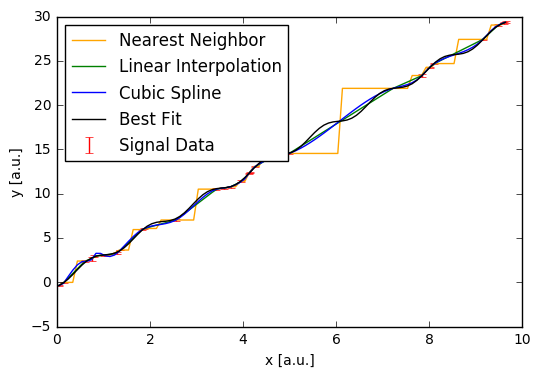

In [2]:
import scipy.interpolate as interp

# interpolate data
near = interp.interp1d(data['x'], data['y'], kind='nearest')  # nearest neighbor interpolation
lin  = interp.interp1d(data['x'], data['y'], kind='linear')   # linear interpolation
cub  = interp.interp1d(data['x'], data['y'], kind='cubic')    # cubic spline interpolation

# plot the results
f, ax = plt.subplots()

ax.errorbar(data['x'], data['y'], yerr=data['yerr'], linestyle='', color='red', label='Signal Data')

x_range = np.arange(min(data['x']), max(data['x']), 0.1)

ax.plot(x_range, near(x_range), color='orange', label='Nearest Neighbor')
ax.plot(x_range, lin(x_range), color='green', label='Linear Interpolation')
ax.plot(x_range, cub(x_range), color='blue', label='Cubic Spline')

# fit function
fit = lambda x: 3.*x+0.005+0.51*np.sin(x/0.2-2)  # see last week's notes
ax.plot(x_range, fit(x_range), color='black', label='Best Fit')

ax.set_xlabel('x [a.u.]')
ax.set_ylabel('y [a.u.]')

ax.legend(numpoints=1, loc=2)

plt.show()


It is obvious that both the linear and cublic Spline interpolations provide good results, but only if the function is reasonably well sampled. Where there are large gaps, all interpolations diverge significantly from the best-fit function.

Now we can integrate the area underneath the different interpolations and the fit curve:

In [12]:
from scipy.integrate import quad

print quad(lin, min(data['x']), max(data['x']))
print quad(cub, min(data['x']), max(data['x']))
print quad(fit, min(data['x']), max(data['x']))

(139.27600970458758, 0.004095538105701735)
(139.39775477612238, 1.714206570357876e-06)
(139.6420242989239, 1.6598776433202067e-10)


`scipy.integrate.quad` integrates the different functions from their minimum to their maximum $x$ values and return the integral value and its uncertainty. Again, the cubic Spline provides more accurate results.

## Multi-dimensional Interpolation

Imagine some function that is defined across the x-y plane.

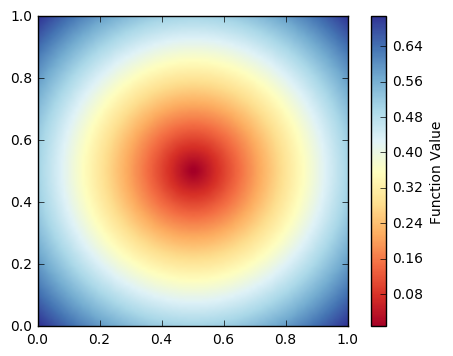

In [3]:
def func(x,y):
    return np.sqrt((.5-x)**2+(.5-y)**2)

# create a meshgrid
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# plot the function values in a scatter plot
f, ax1 = plt.subplots()

polar = ax1.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower',
          cmap='RdYlBu')

# add colorbar
cbar = f.colorbar(polar)
cbar.set_label("Function Value")

plt.show()

`plt.imshow` creates an image from the function `func` over the meshgrid (see below) consisting of `grid_x` and `grid_y`. Please note the `.T` appended to the function call: python uses a matrix indexing convention (rows before columns), whereas an image uses colums before rows. `.T` transposes the shape of the resulting values, leading to a correct representation (which is not really necessary here due to the symmetry of the problem) when using `origin='lower'`.

`cmap='RdYlBu'` defines the colormap to be used in the plotting: Red-Yellow-Blue (see, e.g., https://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/Show_colormaps). 

`np.mgrid` generates a meshgrid. Let's check quickly what it actually does:

In [4]:
x_grid, y_grid = np.mgrid[0:3:1, 0:2:1]
print x_grid
print y_grid

[[0 0]
 [1 1]
 [2 2]]
[[0 1]
 [0 1]
 [0 1]]


`np.mgrid` creates a number of arrays with coordinates that sample a range of numbers evenly and form a grid. Each array represents one axis. In this example, it forms a grid in the x-y plane ranging over $0 < x < 3$ and $0 < y < 2$ with steps of one each. The x and y arrays have the same shape, meaning that iterating over both arrays samples the whole grid:

In [5]:
for i in range(len(np.ravel(x_grid))):
    print np.ravel(x_grid)[i], np.ravel(y_grid)[i]

0 0
0 1
1 0
1 1
2 0
2 1


Hence, `np.grid` can be used to create an evenly sampled grid and the resulting arrays can be readily passed to functions as arguments:

In [6]:
def test_func(x, y):
    return x+y

print test_func(x_grid, y_grid)

[[0 1]
 [1 2]
 [2 3]]


One more addition: meshgrids can be generated for any number of dimensions. The syntax `np.mgrid[0:10:20j...` will generate in one axis coordinates ranging from zero to 10 in 20 steps.

Let's go back to our interpolation problem. We sample our model function `func` randomly across the x-y plane and plot the function values in a scatter plot:

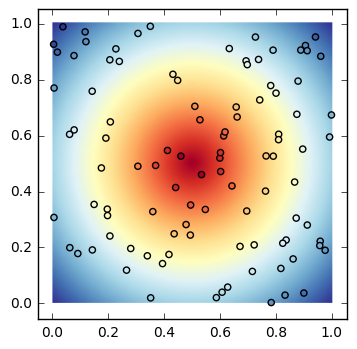

In [7]:
# create fake data in two dimensions
xy_data = np.random.rand(100, 2)
z_data  = func(xy_data[:,0], xy_data[:,1])    

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# plot the function values in a scatter plot
f, ax1 = plt.subplots()

ax1.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower',
          cmap='RdYlBu')

ax1.scatter(xy_data[:,1], xy_data[:,0], label='data', edgecolor='black',
            c=z_data, cmap='RdYlBu')

plt.show()

We now use the function `scipy.interpolate.griddata` to interpolate the randomly sampled data points using different methods and compare them to the original function.

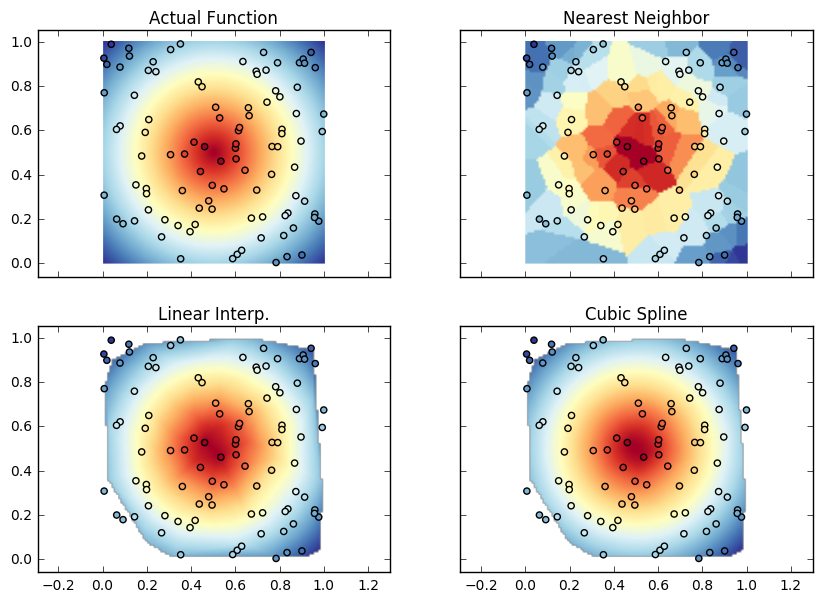

In [8]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# interpolate
grid_znearest = interp.griddata(xy_data, z_data, (grid_x, grid_y), 
                                method='nearest')
grid_zlinear = interp.griddata(xy_data, z_data, (grid_x, grid_y), 
                                method='linear')
grid_zcubic = interp.griddata(xy_data, z_data, (grid_x, grid_y), 
                                method='cubic')

# create 2x2 plot array with shared axes
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                                           figsize=(10,7))

# actual function
ax1.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower',
          cmap='RdYlBu')
# use '.T' to transpose images: python uses row/column notation,
# but images use x,y
ax1.scatter(xy_data[:,1], xy_data[:,0], label='data', edgecolor='black',
            c=z_data, cmap='RdYlBu')
# 'c' is a colormap, check here for available designs
# http://matplotlib.org/examples/color/colormaps_reference.html
ax1.set_title('Actual Function')

# nearest neighbor
ax2.imshow(grid_znearest.T, extent=(0,1,0,1), origin='lower',
           cmap='RdYlBu')
ax2.scatter(xy_data[:,1], xy_data[:,0], label='data', edgecolor='black',
            c=z_data, cmap='RdYlBu')
ax2.set_title('Nearest Neighbor')

# linear
ax3.imshow(grid_zlinear.T, extent=(0,1,0,1), origin='lower',
           cmap='RdYlBu')
ax3.scatter(xy_data[:,1], xy_data[:,0], label='data', edgecolor='black',
            c=z_data, cmap='RdYlBu')
ax3.set_title('Linear Interp.')

# cubic spline
ax4.imshow(grid_zcubic.T, extent=(0,1,0,1), origin='lower',
           cmap='RdYlBu')
ax4.scatter(xy_data[:,1], xy_data[:,0], label='data', edgecolor='black',
            c=z_data, cmap='RdYlBu')
ax4.set_title('Cubic Spline')

plt.show()

Note that the background distribution of the three interpolated plots is derived purely based on the randomly created scatter points. The Nearest Neighbor method creates a rather patchy structure, whereas the linear and cubic Spline interpolations look pretty good. 